In [2]:
# run this and restart the kernel
!pip install --upgrade opencv-python --user

     |████████████████████████████████| 28.2 MB 406 kB/s eta 0:00:01


In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
import cv2

In [4]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

### Analytics on DICOM metadata and DICOM check

Let's see if our model's prediction nearly matches with the Ground truth(silver truth actually) i.e. the labeling provided in the dicom header.

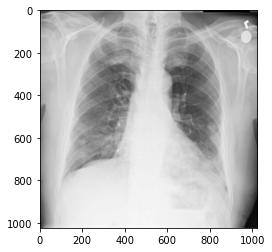

In [15]:
# look at all the info in a dicom file.
x = pydicom.dcmread(test_dicoms[5])
plt.imshow(x.pixel_array, cmap = 'gray')

In [6]:
metadata = []
for each in test_dicoms:
    dcm = pydicom.dcmread(each)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.PatientPosition, dcm.Modality, dcm.StudyDescription, dcm.BodyPartExamined,
              dcm.Rows, dcm.Columns]
    metadata.append(fields)
metadata[0]

['2', 81, 'M', 'PA', 'DX', 'No Finding', 'CHEST', 1024, 1024]

In [7]:
metadf = pd.DataFrame(metadata, 
                      columns = ['PatientID','PatientAge','PatientSex', 'Patient Position','Modality','Findings','BPE','Rows','Columns'])
metadf

,PatientID,PatientAge,PatientSex,Patient Position,Modality,Findings,BPE,Rows,Columns
0,2,81,M,PA,DX,No Finding,CHEST,1024,1024
1,1,58,M,AP,DX,Cardiomegaly,CHEST,1024,1024
2,61,77,M,AP,DX,Effusion,CHEST,1024,1024
3,2,81,M,PA,DX,No Finding,RIBCAGE,1024,1024
4,2,81,M,PA,CT,No Finding,CHEST,1024,1024
5,2,81,M,XX,DX,No Finding,CHEST,1024,1024


We will look for presence of data different than what our model was trained on.
    
    1. 'test4.dcm' indexed 3 has RIBCAGE as body part examined which I checked, is just due to mistake in labeling the image is chest-X ray only. In general, we remove data with mistakes.
    2. 'test5.dcm' has modality as CT. Image when printed looks same as image with DX modality, however like above, we will still likely delete these images.
    3. 'test6.dcm' has unidentified position XX. We can see from the image that it is either AP or PA and XX is mislabled.

### Testing model on DICOMS

In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    # todo
    
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename) 
    
    # some dicom checks. We can add more dicom checks according to our convenience
    if ds.Modality != 'DX':
        return (None, None, None)
    if ds.BodyPartExamined != 'CHEST':
        return (None, None, None)
    if ds.PatientPosition not in ['PA', 'AP']:
        return (None, None, None)
    
    img = ds.pixel_array
    img_mean = np.mean(img)
    img_std = np.std(img)
    
    return (img, img_mean, img_std)
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    # todo
    # resize the image
    res = cv2.resize(img, dsize=img_size[1:3]) # dsize is destinition size
    proc_img = cv2.cvtColor(res,cv2.COLOR_GRAY2RGB)
    #proc_img = proc_img/255.0  # if model was trained with images that we
    proc_img = np.array(proc_img)
    proc_img = (proc_img - img_mean)/img_std
    proc_img = np.reshape(proc_img, img_size)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    # todo
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights(weight_path)
    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    # todo  
    prediction  = model.predict(img)
    if(prediction >=thresh):
        prediction = 1.0
    else:
        prediction = 0.0
    
    return prediction 

### Walkthrough of preprocessing

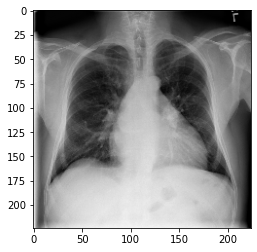

In [4]:
x= pydicom.dcmread('test2.dcm')
img = x.pixel_array
img_mean = np.mean(img)
img_std = np.std(img)
img_size = (1,224,224,3)

res = cv2.resize(img, dsize=img_size[1:3]) # dsize is destinition size
proc_img = cv2.cvtColor(res,cv2.COLOR_GRAY2RGB)
proc_img = proc_img/255.0
proc_img = np.array(proc_img)
proc_img = np.reshape(proc_img, img_size)

plt.imshow(proc_img[0])

### Results of different forms of Normalization.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


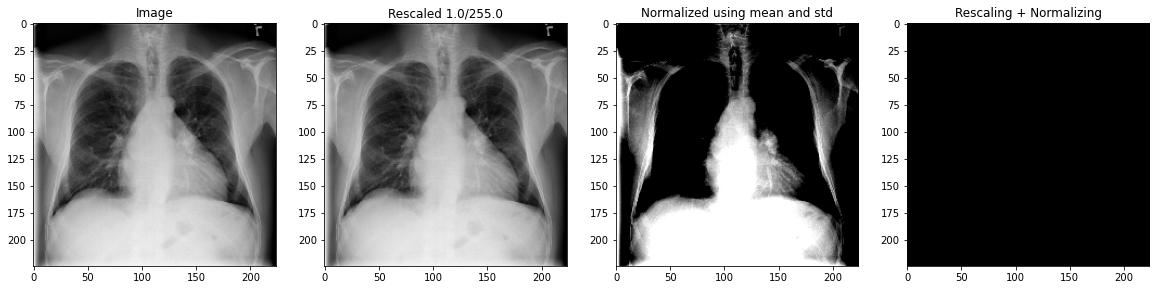

In [5]:
x= pydicom.dcmread('test2.dcm')
img = x.pixel_array
img_mean = np.mean(img)
img_std = np.std(img)
img_size = (1,224,224,3)
res = cv2.resize(img, dsize=img_size[1:3])
proc_img0 = cv2.cvtColor(res,cv2.COLOR_GRAY2RGB)
proc_img1 = proc_img0/255.0 #this is not required if we are standardiszing by image mean and std.
proc_img2 = proc_img0 - img_mean
proc_img2 = proc_img2/img_std
proc_img3 = (proc_img1 - img_mean)/img_std # what if we normalize over rescaling
#plt.imshow(proc_img2, cmap = 'bone') # image after normalizing

images = [proc_img0, proc_img1, proc_img2, proc_img3]
titles = ['Image', 'Rescaled 1.0/255.0', 'Normalized using mean and std', 'Rescaling + Normalizing']
fig, ax = plt.subplots(1,4, figsize = (20,5))
ax = ax.flatten()
for iax, i in zip(ax, range(len(images))):
    iax.imshow(images[i], cmap ='bone')
    iax.set_title(titles[i])

### Prediction on test images.

In [6]:
model_path = 'my_model.json'
weight_path = 'xray_class_standardize_my_model.best.hdf5'

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16

my_model = load_model(model_path, weight_path)
thresh = 0.7144732 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img, img_mean, img_std = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)

Load file test1.dcm ...
0.0
Load file test2.dcm ...
0.0
Load file test3.dcm ...
1.0
Load file test4.dcm ...
0.0
Load file test5.dcm ...
0.0
Load file test6.dcm ...
0.0
